# Modelling

We will experiment with different preprocessing functions and different classifiers to find the best performing model.

## 1.0 Loading Libraries

In [3]:
print ('loading libraries...')
import os

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import config
import utils
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,  confusion_matrix, classification_report
import joblib

loading libraries...


## 2.0 Prepare the Dataset

We need to load the datset and drop the duplicated row. We will select one well from the dataset that we use to test our final model and its plotting function.

In [4]:
#load dataset
filename = 'datasets/facies_data.csv'
data = pd.read_csv(filename)
data = data.drop_duplicates().reset_index(drop=True)
data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [5]:
#select one well for testing
test_well_data = data[data['Well Name'] == 'CHURCHMAN BIBLE']

## 3.0 Model

### 3.1 Train Test Split

We will apply a custom split to the dataset. This follows the mode the model will be used in the field. Well logs are usually generated for a single well at a time. These logs can be passed into the model to predict the facies classes. The dataset we are working with is relatively small compared to the number of classes in the dataset. As a result we will include the test well in the training but will ensure it is in the test part of the split.

In [6]:
#split dataset by well using custom train test split function
train, test = utils.train_test_split_by_well(data, config.TRAIN_SIZE)
train.shape, test.shape

((2714, 11), (517, 11))

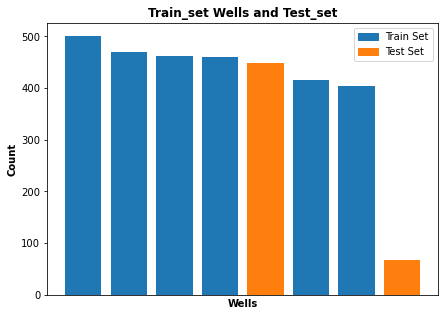

In [7]:
#visualizing the wells in the train and test splits
utils.train_test_plot(data, train, test)

We established from our EDA that the categorical features would not be used for model training. These features are dropped from the dataset at this point. Then the input variables are separated from the target variable.

In [8]:
train = train.drop(['Well Name', 'Formation', 'Depth'], axis =1)
test = test.drop(['Well Name', 'Formation', 'Depth'], axis =1)

In [9]:
train_X = train.drop('Facies', axis = 1)
train_y = train.Facies
test_X = test.drop('Facies', axis = 1)
test_y = test.Facies
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2714, 7), (2714,), (517, 7), (517,))

### 3.2 Experiments

The metric for evaluating the models will be the scikit learnn accuracy score.

### Dummy Classifier

We start off with the modelling experiments with a dummy classifier. The accuracy score for a dummy classifier is 17%. This poor score is not unexpected given the number of classes in the dataset and its size.



In [10]:
model = DummyClassifier(random_state=16)
model.fit(train_X, train_y)
dummy_preds= model.predict(test_X)
acc_metrics = accuracy_score(test_y, dummy_preds)
round(acc_metrics, 2)

0.17

### Pipeline

Let's use a list of pipelines to find a model that can give a fairly better result. To improve the performance of the models in the pipelines, let's also include a preprocessor step before passing training the models. 

First, we create the functions for the creating and fitting the pipeline and a function to calculate the accuracy for each pipeline.

In [11]:
# create and fitting a pipeline 
def create_pipeline(clf, transformer, train_X, train_y):
    pipeline = Pipeline(
        [
            ('transformer', transformer),
            ('clf', clf)
        ]
    )
    pipeline.fit(train_X, train_y)

    return pipeline

# function to calculate the accuracy score for each pipeline
def pipeline_acc_score(pipeline, test_X, test_y):
    preds = pipeline.predict(test_X)

    acc_score_pipeline = accuracy_score(test_y, preds)

    return acc_score_pipeline

Putting the two functions together we create a function that will take a list of models and a list of preprocessors as arguments. The pipelines are fitted to the training data and the accuracy is calculated. The function returns a dataframe with the names of the model, the preprocessor and the accuracy score for every model-processor pipeline.

In [12]:
def evaluate_model(models, preprocessors, train_X, train_y, test_X, test_y):
    models_list = []
    transformer = []
    accuracy = []
    for model in models:
        for preprocessor in preprocessors:
            pipeline = create_pipeline(model, preprocessor, train_X, train_y)
            model_acc_score = pipeline_acc_score(pipeline, test_X, test_y)
            models_list.append(model)
            transformer.append(preprocessor)
            accuracy.append(round(model_acc_score, 2))
    models_evaluation_list = []
    [models_evaluation_list.append([model, preprocessor, accuracy]) 
    for model, preprocessor, accuracy in zip( models_list, transformer, accuracy)]
    # models_evaluation_list = [[models_list, transformer, accuracy]]
    models_evaluation_df = pd.DataFrame(
        models_evaluation_list, 
        columns = ['models', 'transformers', 'accuracy']
    )
    return models_evaluation_df

In [13]:
results = evaluate_model(config.MODELS, config.PREPROCESSORS, train_X, train_y, test_X, test_y)
results

[17:26:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:26:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:26:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:26:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

,models,transformers,accuracy
0,LogisticRegression(),Normalizer(),0.35
1,LogisticRegression(),MinMaxScaler(),0.37
2,LogisticRegression(),StandardScaler(),0.50
3,LogisticRegression(),PowerTransformer(),0.51
4,"(ExtraTreeClassifier(random_state=1693388419),...",Normalizer(),0.53
5,"(ExtraTreeClassifier(random_state=1693388419),...",MinMaxScaler(),0.58
6,"(ExtraTreeClassifier(random_state=1693388419),...",StandardScaler(),0.58
7,"(ExtraTreeClassifier(random_state=1693388419),...",PowerTransformer(),0.57
8,"XGBClassifier(base_score=0.5, booster='gbtree'...",Normalizer(),0.52
9,"XGBClassifier(base_score=0.5, booster='gbtree'...",MinMaxScaler(),0.52


From the results, the ExtraTreeClassifier-PowerTransformer combination has the best accuracy score. We  can then process to use a gridsearchCV to get the best parameter for this model.

### GridsearchCV

After several iterations with and without the preprocessors, it was observed that the best performance is from the default parameters of the model without any preprocessor.

In [14]:
# grid search XTC pipeline
parameters = {
    'clf__n_estimators': [10, 20, 30, 40, 60, 80,],
    'clf__max_depth': [15, 20, 25, 30, 40, 50]
}

CV = StratifiedKFold(n_splits=3)

pipeline = Pipeline(
        [
            ('clf', ExtraTreesClassifier(random_state=16))
        ]
    )

gs_xtc = GridSearchCV(pipeline, parameters, cv=CV, verbose=True)

gs_xtc.fit(train_X, train_y)

gs_xtc_clf_pred = gs_xtc.predict(test_X)
print(gs_xtc.best_score_)
best_parameters = gs_xtc.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
0.5143797160970681
	clf__max_depth: 15
	clf__n_estimators: 60


We use the ExtraTreeClassifier for the next stage of the modelling experiments. We were able to get a 58% percent model performance using default parameters and without any preprocessor.

In [15]:
model = ExtraTreesClassifier(random_state=16)
model.fit(train_X, train_y)

ExtraTreesClassifier(random_state=16)

In [16]:
predictions_standardscaled = model.predict(test_X)
acc_metrics = accuracy_score(test_y, predictions_standardscaled)
round(acc_metrics, 2)

0.58

Before going on, let's use the unskewed function to reduce the skewdness of the data and observe if there will be any improvement in the 58% model performance achieved with the ExtraTreeClassifier.

In [17]:
#unskew the data
data_unskewed = utils.unskew(data)

In [18]:
train_unskewed, test_unskewed = utils.train_test_split_by_well(data_unskewed, config.TRAIN_SIZE)
train_unskewed.shape, test_unskewed.shape

((2714, 11), (517, 11))

In [19]:
train_unskewed = train_unskewed.drop(['Well Name', 'Formation', 'Depth'], axis =1)
test_unskewed = test_unskewed.drop(['Well Name', 'Formation', 'Depth'], axis =1)

In [20]:
train_X_unskewed = train_unskewed.drop('Facies', axis = 1)
train_y_unskewed = train_unskewed.Facies
test_X_unskewed = test_unskewed.drop('Facies', axis = 1)
test_y_unskewed = test_unskewed.Facies
train_X_unskewed.shape, train_y_unskewed.shape, test_X_unskewed.shape, test_y_unskewed.shape

((2714, 7), (2714,), (517, 7), (517,))

In [21]:
model_unskewed = ExtraTreesClassifier(random_state=25)
model_unskewed.fit(train_X_unskewed, train_y_unskewed)

ExtraTreesClassifier(random_state=25)

In [22]:
predictions_unskewed = model_unskewed.predict(test_X_unskewed)
acc_metrics_unskewed = accuracy_score(test_y_unskewed, predictions_unskewed)
acc_metrics_unskewed

0.5764023210831721

The result is close to the 58% earlier achieved. With this result let us try the pipeline list experiment to find if another model can perform better.

In [23]:
results_unskewed = evaluate_model(config.MODELS, config.PREPROCESSORS, train_X_unskewed, train_y_unskewed, test_X_unskewed, test_y_unskewed)
results_unskewed

[17:26:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:26:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:26:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:26:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

,models,transformers,accuracy
0,LogisticRegression(),Normalizer(),0.33
1,LogisticRegression(),MinMaxScaler(),0.40
2,LogisticRegression(),StandardScaler(),0.51
3,LogisticRegression(),PowerTransformer(),0.51
4,"(ExtraTreeClassifier(random_state=709322020), ...",Normalizer(),0.52
5,"(ExtraTreeClassifier(random_state=709322020), ...",MinMaxScaler(),0.59
6,"(ExtraTreeClassifier(random_state=709322020), ...",StandardScaler(),0.59
7,"(ExtraTreeClassifier(random_state=709322020), ...",PowerTransformer(),0.57
8,"XGBClassifier(base_score=0.5, booster='gbtree'...",Normalizer(),0.51
9,"XGBClassifier(base_score=0.5, booster='gbtree'...",MinMaxScaler(),0.52


There was no other model that outperformed the earlier result. Training a model directly outside the pipeline list still did not improve the result.

In [24]:
scaled_train_X = StandardScaler().fit_transform(train_X_unskewed)
model_unskewed = ExtraTreesClassifier(random_state=1719673464)
model.fit(scaled_train_X, train_y_unskewed)

ExtraTreesClassifier(random_state=16)

In [25]:
scaled_test_X = StandardScaler().fit_transform(test_X_unskewed)
predictions_stan_unskewed = model.predict(scaled_test_X)
acc_metrics_stan_unskewed = accuracy_score(test_y_unskewed, predictions_stan_unskewed)
acc_metrics_stan_unskewed

0.5009671179883946

Without an improvement in the model performance with the preprocessors, we can drop the idea of using preprocessors to improve modell performance.

## 4.0 Save Model

We use the ExtraTreeClassifier to train a model and saved it as a joblib file. 

In [26]:
#first is to split the data into train and test
model_train, model_test = utils.train_test_split_by_well(data, config.TRAIN_SIZE)
model_train.shape, model_test.shape

((2714, 11), (517, 11))

In [27]:
#separate the input variables from the target label in the train and test sets
model_train_X = model_train.drop('Facies', axis = 1)
model_train_y = model_train.Facies
model_test_X = model_test.drop('Facies', axis = 1)
model_test_y = model_test.Facies
model_train_X.shape, model_train_y.shape, model_test_X.shape, model_test_y.shape

((2714, 10), (2714,), (517, 10), (517,))

In [28]:
#define a pipeline that can take the training inputs and the training labels, 
# drop the categorical features and fit the training data to the classifier
model_pipeline = Pipeline(
        [
            ('drop_columns', config.DROP_COLUMNS),
            ('clf', ExtraTreesClassifier(random_state=9000))
        ]
    )

In [29]:
model_pipeline.fit(model_train_X, model_train_y)

Pipeline(steps=[('drop_columns',
                 FunctionTransformer(func=<function drop_columns at 0x7fe4723ce550>)),
                ('clf', ExtraTreesClassifier(random_state=9000))])

In [30]:
model_preds = model_pipeline.predict(model_test_X)
model_acc_metrics = accuracy_score(model_test_y, model_preds)
round(model_acc_metrics, 2)

0.6

The model achieved a 60% model accuracy

## 5.0 Model Evaluation

Let's see some evaluation metrics of the ExtraTreeClassifier.

First we will see the features importance plot.

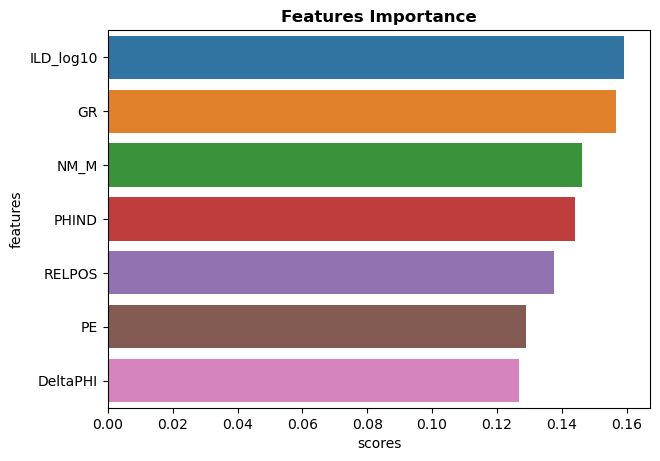

In [31]:
numerical_columns=list(config.drop_columns(model_train_X).columns)
importance = pd.Series(model_pipeline.steps[1][1].feature_importances_, index = np.array(numerical_columns))
importance_df = pd.DataFrame(importance)
importance_df.reset_index(inplace=True)
importance_df.rename(columns={'index':'features', 0:'scores'}, inplace=True)
importance_df.sort_values('scores', ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(7,5), dpi =100)
sns.barplot(
        x ='scores', y = 'features', data = importance_df 
        )
plt.title('Features Importance', fontweight = 'bold')
plt.savefig('images/Features_importance.png')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

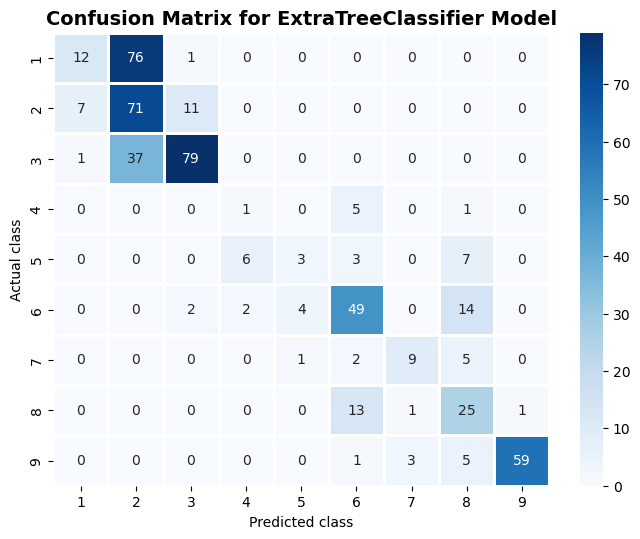

In [32]:
#confusion matrix plot
target = ['1','2','3','4','5','6','7','8','9']
data = confusion_matrix(model_test_y, model_preds)
df_cm = pd.DataFrame(data, columns=target, index = target)
df_cm.index.name = 'Actual class'
df_cm.columns.name = 'Predicted class'
fig, ax = plt.subplots(figsize=(8,6), dpi =100)
plt.title('Confusion Matrix for ExtraTreeClassifier Model', fontsize=14, fontweight='bold')
sns.heatmap(df_cm, cmap='Blues', linewidths=1, annot=True, ax=ax, fmt='g')
plt.savefig('images/Confusion Matrix for ExtraTreeClassifier Model')
plt.show

In [33]:
model_report = classification_report(model_test_y, model_preds, target_names=target)
print(model_report)

              precision    recall  f1-score   support

           1       0.60      0.13      0.22        89
           2       0.39      0.80      0.52        89
           3       0.85      0.68      0.75       117
           4       0.11      0.14      0.12         7
           5       0.38      0.16      0.22        19
           6       0.67      0.69      0.68        71
           7       0.69      0.53      0.60        17
           8       0.44      0.62      0.52        40
           9       0.98      0.87      0.92        68

    accuracy                           0.60       517
   macro avg       0.57      0.51      0.51       517
weighted avg       0.66      0.60      0.58       517



There are some points we can pick from looking closely at these evaluation metrics. 
- There is no dominant features in the dataset with respect to the importance to the model
- The apparent size of some of the classes in the dataset. Specifically classes 4, 5 and 7. 
- The misclassifications we see in the cconfusion matrix. This can also be linked to the size of individual classes in the dataset. The misclassifications are more noticeable in the classes with fewer occurrences.

In [34]:
#save the model in a .joblib file
filename = 'facies_classification_model.joblib'
joblib.dump(model_pipeline, filename)

['facies_classification_model.joblib']

## 6.0 Visualising Predictions

Let's take our test well to trial the saved model. We will use the function that plots the logs and the facies of a well, add some functionalities to it and be able to represent the predictions in a plot.

The function for plotting the predictions takes the data (without labels of course) and first make predictions based on the data. The predicted labels are joined to the data and plotted as shown in the plot we have below.

In [35]:
test_well_input_data = test_well_data.drop('Facies', axis = 1)

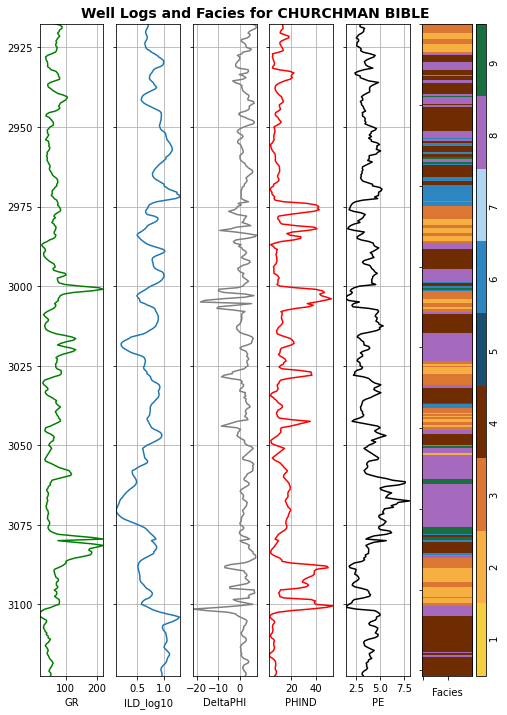

In [36]:
utils.plot_predictions(test_well_input_data, 'facies_classification_model.joblib')

This plot will be used in the deployed app as its output when it receives the logs of a well corresponding to the training data of the model as its input.

## 7.0 Dashboard

Let's create a csv file from the test_well dataframe that will be used to trial our dashboard.

In [37]:
test_well_data = test_well_data.drop('Facies', axis = 1)
model = joblib.load('facies_classification_model.joblib')
test_well_predictions = model.predict(test_well_data)
test_well_data['Facies'] = test_well_predictions

test_well_csv = test_well_data.to_csv('test_well.csv', index = False)

In [38]:
app_test_well = test_well_data.drop('Facies', axis = 1)
app_test_well_csv = app_test_well.to_csv('app_test_well.csv', index = False)